In [1]:
# Imports
from glrm.loss import QuadraticLoss, HingeLoss, OrdinalLoss, CategoricalLoss
from glrm.reg import QuadraticReg
from glrm.glrm import GLRM
from glrm.convergence import Convergence
from glrm.util import pplot
from numpy.random import randn, choice, seed
from itertools import product
from numpy import sign, ceil, hstack
import numpy as np
import matplotlib.pyplot as plt
import math
from statistics import mean, stdev
import sys, os
import pandas as pd

In [2]:
class NormalisedRMSErr():
    def __call__(self, A, A_hat): 
        #Normalize by the standard deviation of each column
        mask = np.tile(np.std(A, axis=0), (len(A), 1))
        A_diff = np.divide((A - A_hat), mask)
        return math.sqrt(np.mean(np.square(A_diff)))

class OrdErr():
    def __call__(self, A, A_hat): 
        A_diff = np.abs(A - A_hat)
        return np.sum(np.vectorize(cumu_sum)(A_diff)) / A_diff.size

class ClassErr():
    def __call__(self, A, A_hat): 
        A_diff = A - A_hat
        return np.count_nonzero(A_diff) / A_diff.size
    
class CategoricalClassErr():
    def __init__(self, decoder):
        self.decoder = decoder
    def __call__(self, A, A_hat): 
        A_diff = A - A_hat
        return np.count_nonzero(A_diff) / (A_diff.shape[0]*len(self.decoder)*2)
    
def cumu_sum(x):
    return sum(i+1 for i in range(int(x)))

In [3]:
def k_vary_exp(A, loss, regX, regY, converge, ns, pred_errs, k_exp_list, exp_name, iterations, decoder=None):
    # Compute average of errors for each rank
    file_path = 'k_vary_exp_outputs/'+ exp_name + '.txt'
    if os.path.exists(file_path):
          os.remove(file_path)
    cumsum_ns = np.insert(np.cumsum(ns), 0,0)
    k_list = []
    mean_errs = [[] for i in range(len(ns))]
    std_dev_errs = [[] for i in range(len(ns))]
    
    # Make sure all your effort is not lost if something does happen to go wrong
    try:
        for k_model in k_exp_list:
            with open(file_path, 'a+') as file:
                file.write('----- RANK {} -----\n'.format(k_model))
            k_fixed_errs = [[] for i in range(len(ns))]
            for i in range(iterations):
                try:
                    model = GLRM(A, loss, regX, regY, k_model, converge = converge, obj_type = 1, decoder=decoder)
                    model.fit();
                    print('Error here')
                    A_hat = model.predict() # prediction matrix
                    print('Or here?')
                    for j in range(len(ns)):
                        k_fixed_errs[j].append(pred_errs[j](A[j], A_hat[:, cumsum_ns[j]:cumsum_ns[j+1]]))
                except:
                    with open(file_path, 'a+') as file:
                        file.write('Error encountered on iteration {}\n'.format(i))
                    pass
            if len(k_fixed_errs[0]) != 0:
                k_list.append(k_model)
                for j in range(len(ns)):
                    mean_errs[j].append(mean(k_fixed_errs[j]))
                    std_dev_errs[j].append(stdev(k_fixed_errs[j]))
                with open(file_path, 'a+') as file:
                    file.write('Mean Prediction Errors - ' + str([m[-1] for m in mean_errs]) + '\n')
                    file.write('Std Dev - ' + str([s[-1] for s in std_dev_errs]) + '\n')
    except:
        print('Experiment terminated prematurely. Saving history...')

    # Save data to dataframe for future use
    data = {
        "Rank" : k_list,
    }
    for i in range(len(ns)):
        data['Mean Error {}'.format(i+1)] = mean_errs[i]
        data['Std Dev {}'.format(i+1)] = std_dev_errs[i]
    df = pd.DataFrame.from_dict(data)
    df.to_csv('k_vary_exp_outputs/'+ exp_name + '.csv')
    
    return k_list, mean_errs, std_dev_errs

# Experiment 1

80 by 60 data matrix with the same number of columns each for real-numbered, ordinal and boolean data.

In [89]:
seed(1)
# Generate problem data
m, k = 80, 10
n1 = 20 # cols of numerical data
n2 = 20 # cols of ordinal data
n3 = 20 # cols of boolean data
ns = [n1, n2, n3]
n = n1+n2+n3
data = randn(m,k).dot(randn(k,n))
data_real = data[:,:n1] # numerical data
data_ord = data[:,n1:n1+n2] 
data_ord = data_ord - data_ord.min() # scale data to be 0 or larger
data_ord = (data_ord/data_ord.max()*6 + 1).round()# round numbers spanning 1 to 7 ordinal data, e.g., 7 point Likert scale
data_bool = sign(data[:,n1+n2:])

# Initialize model
A = [data_real, data_ord, data_bool]
loss = [QuadraticLoss, OrdinalLoss, HingeLoss]
regX, regY = QuadraticReg(0.01), QuadraticReg(0.01)
converge = Convergence(TOL = 1e-3, max_iters = 1000, max_buffer=10) # optional (default TOL = 1e-3)

# Initialize experiment params
pred_errs = [NormalisedRMSErr(), OrdErr(), ClassErr()]
k_exp_list = list(range(1, 34, 2)) + list(range(35, 61, 5))
#k_exp_list = range(1, 2)
exp_name = '4-11-Exp-1'
iterations = 10

/Users/ongrayyi/opt/anaconda3/envs/iibproject/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [5]:
%%capture
k_list, mean_errs, std_dev_errs = k_vary_exp(A, loss, regX, regY, converge, ns, pred_errs, k_exp_list, exp_name, iterations)

In [60]:
# Load data from csv

df = pd.read_csv('k_vary_exp_outputs/4-11-Exp-1.csv')
k_list = df['Rank']
mean_errs = [df[h] for h in list(df) if 'Mean' in h]
std_dev_errs = [df[h] for h in list(df) if 'Std' in h]

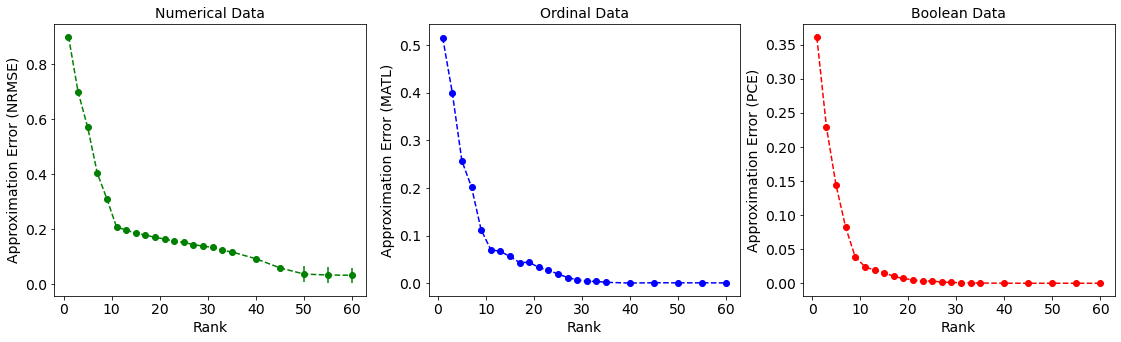

In [61]:
# Plot graphs

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(19, 5))
ax1.errorbar(k_list, mean_errs[0], yerr=std_dev_errs[0], fmt='go--')
ax1.set_title('Numerical Data', fontsize=14)
ax1.set_xlabel('Rank', fontsize=14)
ax1.set_ylabel('Approximation Error (NRMSE)', fontsize=14)
ax1.tick_params(axis='x', labelsize=14)
ax1.tick_params(axis='y', labelsize=14)
ax2.errorbar(k_list, mean_errs[1], yerr=std_dev_errs[1], fmt='bo--')
ax2.set_title('Ordinal Data', fontsize=14)
ax2.set_xlabel('Rank', fontsize=14)
ax2.set_ylabel('Approximation Error (MATL)', fontsize=14)
ax2.tick_params(axis='x', labelsize=14)
ax2.tick_params(axis='y', labelsize=14)
ax3.errorbar(k_list, mean_errs[2], yerr=std_dev_errs[2], fmt='ro--')
ax3.set_title('Boolean Data', fontsize=14)
ax3.set_xlabel('Rank', fontsize=14)
ax3.set_ylabel('Approximation Error (PCE)', fontsize=14)
ax3.tick_params(axis='x', labelsize=14)
ax3.tick_params(axis='y', labelsize=14)
plt.show()
#plt.savefig('k_vary_exp_outputs/11-11-Exp-1.pdf')

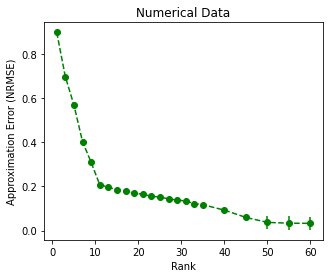

In [66]:
plt.figure(figsize=(5, 4))
plt.errorbar(k_list, mean_errs[0], yerr=std_dev_errs[0], fmt='go--')
plt.title('Numerical Data')
plt.xlabel('Rank')
plt.ylabel('Approximation Error (NRMSE)')
#plt.xticks(fontsize=14)
#plt.yticks(fontsize=14)
plt.savefig('k_vary_exp_outputs/11-11-Exp-1-Num.pdf')

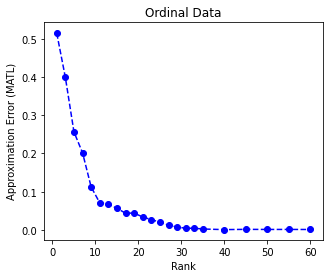

In [67]:
plt.figure(figsize=(5, 4))
plt.errorbar(k_list, mean_errs[1], yerr=std_dev_errs[1], fmt='bo--')
plt.title('Ordinal Data')
plt.xlabel('Rank')
plt.ylabel('Approximation Error (MATL)')
#plt.xticks(fontsize=14)
#plt.yticks(fontsize=14)
plt.savefig('k_vary_exp_outputs/11-11-Exp-1-Ord.pdf')

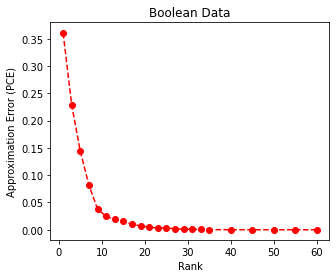

In [68]:
plt.figure(figsize=(5, 4))
plt.errorbar(k_list, mean_errs[2], yerr=std_dev_errs[2], fmt='ro--')
plt.title('Boolean Data')
plt.xlabel('Rank')
plt.ylabel('Approximation Error (PCE)')
#plt.xticks(fontsize=14)
#plt.yticks(fontsize=14)
plt.savefig('k_vary_exp_outputs/11-11-Exp-1-Bool.pdf')

/Users/ongrayyi/opt/anaconda3/envs/iibproject/lib/python3.8/site-packages/GLRM-0.0.1-py3.8.egg/glrm/glrm.py:220: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/ongrayyi/opt/anaconda3/envs/iibproject/lib/python3.8/site-packages/cvxpy/expressions/expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
/Users/ongrayyi/opt/anaconda3/envs/iibproject/lib/python3.8/site-packages/cvxpy/expressions/expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplica

---------- ITERATION 0 ----------


/Users/ongrayyi/opt/anaconda3/envs/iibproject/lib/python3.8/site-packages/cvxpy/problems/problem.py:1060: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Residual norm for X minimization: 1389.1880478092953
Residual norm for Y minimization: 74.0781609594928
Residual norm for Y minimization: 602.4807572933914
Residual norm for Y minimization: 273.7890487210665
---------- ITERATION 1 ----------
Residual norm for X minimization: 1008.415296793302
Residual norm for Y minimization: 82.72017862928824
Residual norm for Y minimization: 603.4887661639631
Residual norm for Y minimization: 244.7919676318823
---------- ITERATION 2 ----------
Residual norm for X minimization: 965.8489820288634
Residual norm for Y minimization: 82.38449016683103
Residual norm for Y minimization: 592.6646229176166
Residual norm for Y minimization: 249.48395789332653
---------- ITERATION 3 ----------
Residual norm for X minimization: 951.0393379837143
Residual norm for Y minimization: 80.12489897343657
Residual norm for Y minimization: 587.2130363457455
Residual norm for Y minimization: 253.98885038587807
---------- ITERATION 4 ----------
Residual norm for X minimizati

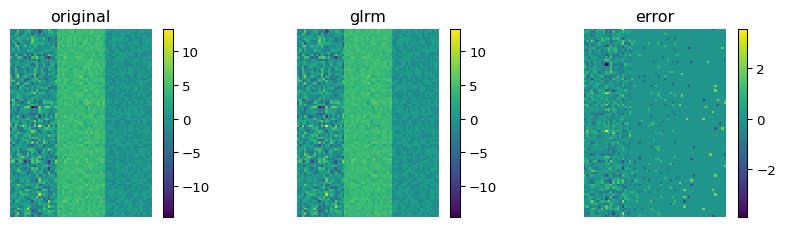

In [90]:
# Example for rank 10

model = GLRM(A, loss, regX, regY, 10, converge = converge, obj_type = 1)
model.fit()

X, Y = model.factors()
A_hat = model.predict() # glrm_pca.predict(X, Y) works too; returns decode(XY)
A_diff = hstack(A)-A_hat # original A minus predicted A
pplot([hstack(A), A_hat, A_diff], ["original", "glrm", "error"])

# Experiment 2

50 by 40 matrix of pure boolean data.

In [82]:
seed(1)
# Generate problem data
m, k = 50, 8
n1 = 40 # cols of boolean data
ns = [n1]
n = n1
data = randn(m,k).dot(randn(k,n))
data_bool = sign(data[:,:])

# Initialize model
A = [data_bool]
loss = [HingeLoss]
regX, regY = QuadraticReg(0.01), QuadraticReg(0.01)
converge = Convergence(TOL = 1e-3, max_iters = 1000, max_buffer=10) # optional (default TOL = 1e-3)

# Initialize experiment params
pred_errs = [ClassErr()]
k_exp_list = list(range(1, 13, 2)) + list(range(15, 41, 5))
exp_name = '11-11-Exp-2'
iterations = 10

In [23]:
%%capture
k_list, mean_errs, std_dev_errs = k_vary_exp(A, loss, regX, regY, converge, ns, pred_errs, k_exp_list, exp_name, iterations)

In [69]:
# Load data from csv

df = pd.read_csv('k_vary_exp_outputs/11-11-Exp-2.csv')
k_list = df['Rank']
mean_err = df['Mean Error 1']
std_dev_err = df['Std Dev 1']

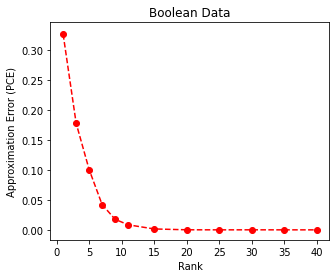

In [70]:
# Plot graphs
plt.figure(figsize=(5, 4))
plt.errorbar(k_list, mean_err, yerr=std_dev_err, fmt='ro--')
plt.title('Boolean Data')
plt.xlabel('Rank')
plt.ylabel('Approximation Error (PCE)')
#plt.show()
plt.savefig('k_vary_exp_outputs/11-11-Exp-2.pdf')

/Users/ongrayyi/opt/anaconda3/envs/iibproject/lib/python3.8/site-packages/GLRM-0.0.1-py3.8.egg/glrm/glrm.py:220: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/ongrayyi/opt/anaconda3/envs/iibproject/lib/python3.8/site-packages/cvxpy/expressions/expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
/Users/ongrayyi/opt/anaconda3/envs/iibproject/lib/python3.8/site-packages/cvxpy/expressions/expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplica

---------- ITERATION 0 ----------


/Users/ongrayyi/opt/anaconda3/envs/iibproject/lib/python3.8/site-packages/cvxpy/problems/problem.py:1060: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Residual norm for X minimization: 361.1269744190535
Residual norm for Y minimization: 227.92189658497097
---------- ITERATION 1 ----------
Residual norm for X minimization: 218.20587487846808
Residual norm for Y minimization: 202.69465909510197
---------- ITERATION 2 ----------
Residual norm for X minimization: 194.60832541890562
Residual norm for Y minimization: 189.01122288055268
---------- ITERATION 3 ----------
Residual norm for X minimization: 187.8191557070303
Residual norm for Y minimization: 184.76042345282903
---------- ITERATION 4 ----------
Residual norm for X minimization: 184.26829160669345
Residual norm for Y minimization: 182.88978546356563
---------- ITERATION 5 ----------
Residual norm for X minimization: 181.4880685346712
Residual norm for Y minimization: 181.86211594109375
---------- ITERATION 6 ----------
Residual norm for X minimization: 180.77915091433954
Residual norm for Y minimization: 180.04115272347516
---------- ITERATION 7 ----------
Residual norm for X min

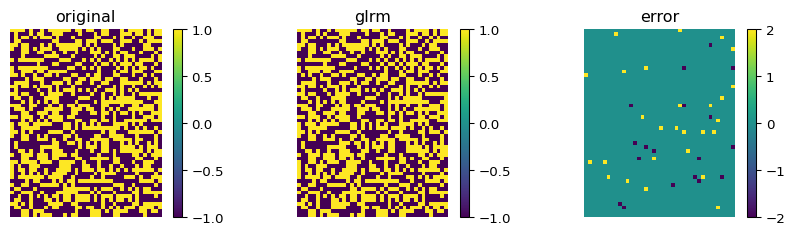

In [83]:
# Example for rank 8

model = GLRM(A, loss, regX, regY, 8, converge = converge, obj_type = 1)
model.fit()

X, Y = model.factors()
A_hat = model.predict() # glrm_pca.predict(X, Y) works too; returns decode(XY)
A_diff = hstack(A)-A_hat # original A minus predicted A
pplot([hstack(A), A_hat, A_diff], ["original", "glrm", "error"])

# Experiment 3

50 by 40 matrix of pure ordinal data.

In [84]:
seed(1)
# Generate problem data
m, k = 50, 8
n1 = 40 # cols of ordinal data
ns = [n1]
n = n1
data = randn(m,k).dot(randn(k,n))
data_ord = data[:,:] 
data_ord = data_ord - data_ord.min() # scale data to be 0 or larger
data_ord = (data_ord/data_ord.max()*6 + 1).round()# round numbers spanning 1 to 7 ordinal data, e.g., 7 point Likert scale

# Initialize model
A = [data_ord]
loss = [OrdinalLoss]
regX, regY = QuadraticReg(0.01), QuadraticReg(0.01)
converge = Convergence(TOL = 1e-3, max_iters = 1000, max_buffer=10) # optional (default TOL = 1e-3)

# Initialize experiment params
pred_errs = [OrdErr()]
k_exp_list = list(range(1, 13, 2)) + list(range(15, 41, 5))
exp_name = '11-11-Exp-3'
iterations = 10

/Users/ongrayyi/opt/anaconda3/envs/iibproject/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [32]:
%%capture
k_list, mean_errs, std_dev_errs = k_vary_exp(A, loss, regX, regY, converge, ns, pred_errs, k_exp_list, exp_name, iterations)

In [71]:
# Load data from csv

df = pd.read_csv('k_vary_exp_outputs/11-11-Exp-3.csv')
k_list = df['Rank']
mean_err = df['Mean Error 1']
std_dev_err = df['Std Dev 1']

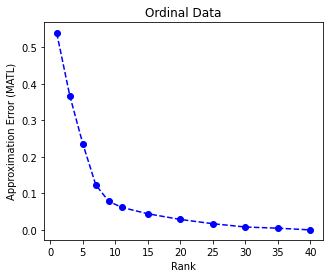

In [72]:
# Plot graphs
plt.figure(figsize=(5, 4))
plt.errorbar(k_list, mean_err, yerr=std_dev_err, fmt='bo--')
plt.title('Ordinal Data')
plt.xlabel('Rank')
plt.ylabel('Approximation Error (MATL)')
#plt.show()
plt.savefig('k_vary_exp_outputs/11-11-Exp-3.pdf')

/Users/ongrayyi/opt/anaconda3/envs/iibproject/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/Users/ongrayyi/opt/anaconda3/envs/iibproject/lib/python3.8/site-packages/GLRM-0.0.1-py3.8.egg/glrm/glrm.py:220: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/ongrayyi/opt/anaconda3/envs/iibproject/lib/python3.8/site-packages/cvxpy/expressions/expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-sc

---------- ITERATION 0 ----------


/Users/ongrayyi/opt/anaconda3/envs/iibproject/lib/python3.8/site-packages/cvxpy/problems/problem.py:1060: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Residual norm for X minimization: 712.6241421821502
Residual norm for Y minimization: 709.396660149271
---------- ITERATION 1 ----------
Residual norm for X minimization: 680.6112202481293
Residual norm for Y minimization: 699.4968722285696
---------- ITERATION 2 ----------
Residual norm for X minimization: 676.2444506372348
Residual norm for Y minimization: 696.0860347831173
---------- ITERATION 3 ----------
Residual norm for X minimization: 674.553029450277
Residual norm for Y minimization: 696.0183582912745
---------- ITERATION 4 ----------
Residual norm for X minimization: 674.1298800726207
Residual norm for Y minimization: 695.0414672025507


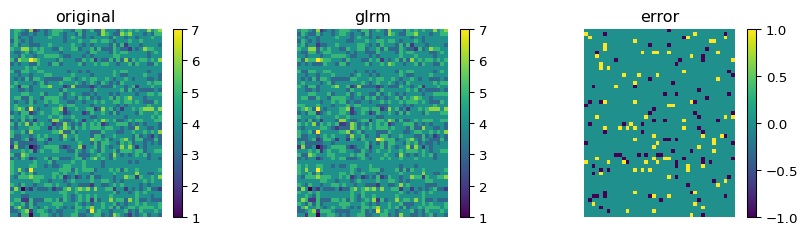

In [86]:
# Example for rank 8
model = GLRM(A, loss, regX, regY, 8, converge = converge, obj_type = 1)
model.fit()

X, Y = model.factors()
A_hat = model.predict() # glrm_pca.predict(X, Y) works too; returns decode(XY)
A_diff = hstack(A)-A_hat # original A minus predicted A
pplot([hstack(A), A_hat, A_diff], ["original", "glrm", "error"])

# Experiment 4

50 by 40 matrix of pure categorical data (one hot encoded). Each block of 4 columns represents on data point (because there are 4 categories).

In [87]:
seed(1)
# Generate problem data
m, k = 50, 8
n1 = 40 # cols of boolean data
ns = [n1]
n = n1
decoder = [[4]*10]
data = randn(m,k).dot(randn(k,n))

for i in range(data.shape[0]):
    for j in range(10):
        max_index = np.argmax(data[i, 4*j:4*(j+1)])
        for k in range(4):
            if k == max_index:
                data[i, 4*j + k] = 1
            else:
                data[i, 4*j + k] = -1
                
# Initialize model
A = [data]
loss = [CategoricalLoss]
regX, regY = QuadraticReg(0.01), QuadraticReg(0.01)
converge = Convergence(TOL = 1e-3, max_iters = 1000, max_buffer=10) # optional (default TOL = 1e-3)

# Initialize experiment params
pred_errs = [CategoricalClassErr(decoder[0])]
k_exp_list = list(range(1, 13, 2)) + list(range(15, 41, 5))
exp_name = '11-11-Exp-4'
iterations = 10

/Users/ongrayyi/opt/anaconda3/envs/iibproject/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [43]:
%%capture
k_list, mean_errs, std_dev_errs = k_vary_exp(A, loss, regX, regY, converge, ns, pred_errs, k_exp_list, exp_name, iterations, decoder)

In [73]:
# Load data from csv

df = pd.read_csv('k_vary_exp_outputs/11-11-Exp-4.csv')
k_list = df['Rank']
mean_err = df['Mean Error 1']
std_dev_err = df['Std Dev 1']

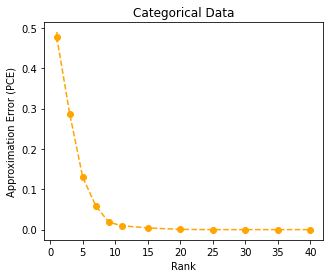

In [74]:
# Plot graphs
plt.figure(figsize=(5, 4))
plt.errorbar(k_list, mean_err, yerr=std_dev_err, fmt='o--', color='orange')
plt.title('Categorical Data')
plt.xlabel('Rank')
plt.ylabel('Approximation Error (PCE)')
#plt.show()
plt.savefig('k_vary_exp_outputs/11-11-Exp-4.pdf')

/Users/ongrayyi/opt/anaconda3/envs/iibproject/lib/python3.8/site-packages/GLRM-0.0.1-py3.8.egg/glrm/glrm.py:220: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/ongrayyi/opt/anaconda3/envs/iibproject/lib/python3.8/site-packages/cvxpy/expressions/expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
/Users/ongrayyi/opt/anaconda3/envs/iibproject/lib/python3.8/site-packages/cvxpy/expressions/expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplica

---------- ITERATION 0 ----------


/Users/ongrayyi/opt/anaconda3/envs/iibproject/lib/python3.8/site-packages/cvxpy/problems/problem.py:1060: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Residual norm for X minimization: 905.054903350421
Residual norm for Y minimization: 616.5024390758825
---------- ITERATION 1 ----------
Residual norm for X minimization: 551.2931694207743
Residual norm for Y minimization: 525.5660321743245
---------- ITERATION 2 ----------
Residual norm for X minimization: 510.1406470082259
Residual norm for Y minimization: 501.5038039142114
---------- ITERATION 3 ----------
Residual norm for X minimization: 493.2874121123762
Residual norm for Y minimization: 486.22116900162814
---------- ITERATION 4 ----------
Residual norm for X minimization: 483.07972517456886
Residual norm for Y minimization: 477.61913051652107
---------- ITERATION 5 ----------
Residual norm for X minimization: 474.0670028714248
Residual norm for Y minimization: 470.1206403194065
---------- ITERATION 6 ----------
Residual norm for X minimization: 467.15944017860534
Residual norm for Y minimization: 463.73636961061806
---------- ITERATION 7 ----------
Residual norm for X minimizati

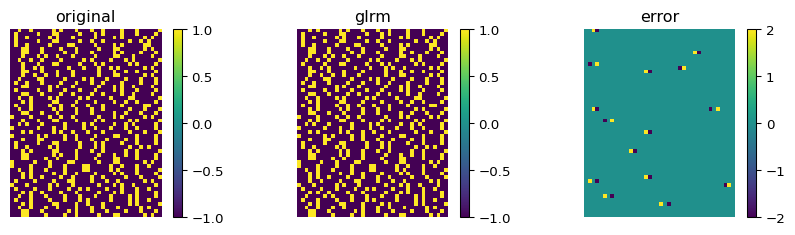

In [88]:
# Example for rank 8
model = GLRM(A, loss, regX, regY, 8, converge = converge, obj_type = 1, decoder=decoder)
model.fit()

X, Y = model.factors()
A_hat = model.predict() # glrm_pca.predict(X, Y) works too; returns decode(XY)
A_diff = hstack(A)-A_hat # original A minus predicted A
pplot([hstack(A), A_hat, A_diff], ["original", "glrm", "error"])

# Experiment 5

80 by 60 matrix with dominance of boolean data over ordinal and real-numbered data.

In [91]:
seed(1)
# Generate problem data
m, k = 80, 10
n1 = 10 # cols of numerical data
n2 = 10 # cols of ordinal data
n3 = 40 # cols of boolean data
ns = [n1, n2, n3]
n = n1+n2+n3
data = randn(m,k).dot(randn(k,n))
data_real = data[:,:n1] # numerical data
data_ord = data[:,n1:n1+n2] 
data_ord = data_ord - data_ord.min() # scale data to be 0 or larger
data_ord = (data_ord/data_ord.max()*6 + 1).round()# round numbers spanning 1 to 7 ordinal data, e.g., 7 point Likert scale
data_bool = sign(data[:,n1+n2:])

# Initialize model
A = [data_real, data_ord, data_bool]
loss = [QuadraticLoss, OrdinalLoss, HingeLoss]
regX, regY = QuadraticReg(0.01), QuadraticReg(0.01)
converge = Convergence(TOL = 1e-3, max_iters = 1000, max_buffer=10) # optional (default TOL = 1e-3)

# Initialize experiment params
pred_errs = [NormalisedRMSErr(), OrdErr(), ClassErr()]
# k_exp_list = list(range(1, 14, 2)) + list(range(15, 36, 5))
k_exp_list = list(range(40, 61, 5))
exp_name = '4-11-Exp-5.2'
iterations = 10

/Users/ongrayyi/opt/anaconda3/envs/iibproject/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [5]:
%%capture
k_list, mean_errs, std_dev_errs = k_vary_exp(A, loss, regX, regY, converge, ns, pred_errs, k_exp_list, exp_name, iterations)

In [7]:
%%capture
k_list_2, mean_errs_2, std_dev_errs_2 = k_vary_exp(A, loss, regX, regY, converge, ns, pred_errs, k_exp_list, exp_name, iterations)

In [75]:
# Load data from csv

df_1 = pd.read_csv('k_vary_exp_outputs/4-11-Exp-5.1.csv')
k_list = list(df_1['Rank'])
mean_errs = [list(df_1[h]) for h in list(df_1) if 'Mean' in h]
std_dev_errs = [list(df_1[h]) for h in list(df_1) if 'Std' in h]

df_2 = pd.read_csv('k_vary_exp_outputs/4-11-Exp-5.2.csv')
k_list_2 = list(df_2['Rank'])
mean_errs_2 = [list(df_2[h]) for h in list(df_2) if 'Mean' in h]
std_dev_errs_2 = [list(df_2[h]) for h in list(df_2) if 'Std' in h]

In [76]:
k_list = k_list + k_list_2
mean_errs = mean_errs + mean_errs_2
std_dev_errs = std_dev_errs + std_dev_errs_2

In [77]:
mean_errs[0] = mean_errs[0] + mean_errs[3]
mean_errs[1] = mean_errs[1] + mean_errs[4]
mean_errs[2] = mean_errs[2] + mean_errs[5]
mean_errs = mean_errs[:3]

In [78]:
std_dev_errs[0] = std_dev_errs[0] + std_dev_errs[3]
std_dev_errs[1] = std_dev_errs[1] + std_dev_errs[4]
std_dev_errs[2] = std_dev_errs[2] + std_dev_errs[5]
std_dev_errs = std_dev_errs[:3]

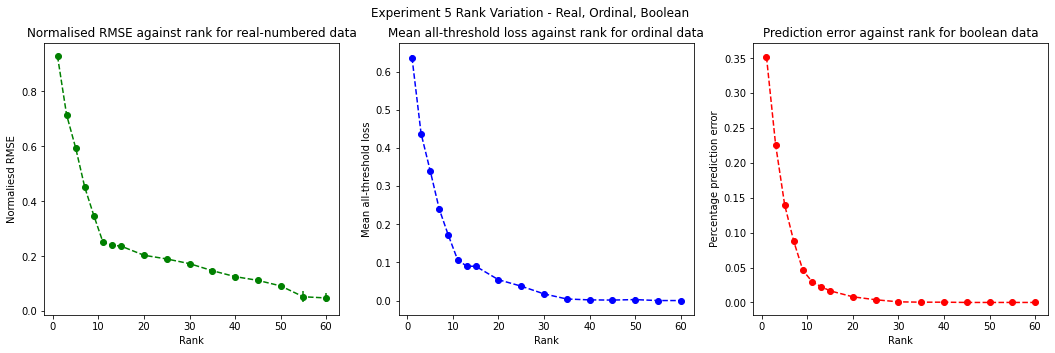

In [55]:
# Plot graphs

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))
ax1.errorbar(k_list, mean_errs[0], yerr=std_dev_errs[0], fmt='go--')
ax1.set_title('Normalised RMSE against rank for real-numbered data')
ax1.set_xlabel('Rank')
ax1.set_ylabel('Normaliesd RMSE')
ax2.errorbar(k_list, mean_errs[1], yerr=std_dev_errs[1], fmt='bo--')
ax2.set_title('Mean all-threshold loss against rank for ordinal data')
ax2.set_xlabel('Rank')
ax2.set_ylabel('Mean all-threshold loss')
ax3.errorbar(k_list, mean_errs[2], yerr=std_dev_errs[2], fmt='ro--')
ax3.set_title('Prediction error against rank for boolean data')
ax3.set_xlabel('Rank')
ax3.set_ylabel('Percentage prediction error')
plt.suptitle('Experiment 5 Rank Variation - Real, Ordinal, Boolean')
plt.show()
#plt.savefig('k_vary_exp_outputs/11-11-Exp-5.png')

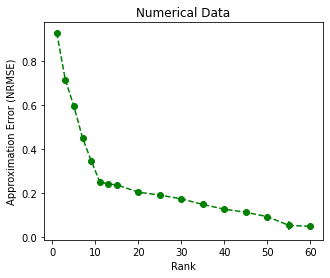

In [79]:
plt.figure(figsize=(5, 4))
plt.errorbar(k_list, mean_errs[0], yerr=std_dev_errs[0], fmt='go--')
plt.title('Numerical Data')
plt.xlabel('Rank')
plt.ylabel('Approximation Error (NRMSE)')
#plt.xticks(fontsize=14)
#plt.yticks(fontsize=14)
plt.savefig('k_vary_exp_outputs/11-11-Exp-5-Num.pdf')

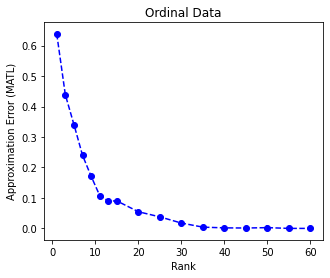

In [80]:
plt.figure(figsize=(5, 4))
plt.errorbar(k_list, mean_errs[1], yerr=std_dev_errs[1], fmt='bo--')
plt.title('Ordinal Data')
plt.xlabel('Rank')
plt.ylabel('Approximation Error (MATL)')
#plt.xticks(fontsize=14)
#plt.yticks(fontsize=14)
plt.savefig('k_vary_exp_outputs/11-11-Exp-5-Ord.pdf')

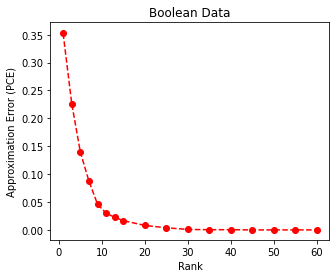

In [81]:
plt.figure(figsize=(5, 4))
plt.errorbar(k_list, mean_errs[2], yerr=std_dev_errs[2], fmt='ro--')
plt.title('Boolean Data')
plt.xlabel('Rank')
plt.ylabel('Approximation Error (PCE)')
#plt.xticks(fontsize=14)
#plt.yticks(fontsize=14)
plt.savefig('k_vary_exp_outputs/11-11-Exp-5-Bool.pdf')

/Users/ongrayyi/opt/anaconda3/envs/iibproject/lib/python3.8/site-packages/GLRM-0.0.1-py3.8.egg/glrm/glrm.py:220: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/ongrayyi/opt/anaconda3/envs/iibproject/lib/python3.8/site-packages/cvxpy/expressions/expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
/Users/ongrayyi/opt/anaconda3/envs/iibproject/lib/python3.8/site-packages/cvxpy/expressions/expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplica

---------- ITERATION 0 ----------


/Users/ongrayyi/opt/anaconda3/envs/iibproject/lib/python3.8/site-packages/cvxpy/problems/problem.py:1060: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Residual norm for X minimization: 1471.0662546093379
Residual norm for Y minimization: 53.09199038468111
Residual norm for Y minimization: 306.4360037207779
Residual norm for Y minimization: 546.014612026688
---------- ITERATION 1 ----------
Residual norm for X minimization: 954.119104681134
Residual norm for Y minimization: 58.00886750513425
Residual norm for Y minimization: 318.673325981951
Residual norm for Y minimization: 508.75418197634593
---------- ITERATION 2 ----------
Residual norm for X minimization: 919.2231711051448
Residual norm for Y minimization: 57.90898749707718
Residual norm for Y minimization: 313.0181690902312
Residual norm for Y minimization: 521.1905387505059
---------- ITERATION 3 ----------
Residual norm for X minimization: 911.5894393991088
Residual norm for Y minimization: 57.58353575585238
Residual norm for Y minimization: 309.02507809174574
Residual norm for Y minimization: 530.1913798563587
---------- ITERATION 4 ----------
Residual norm for X minimization

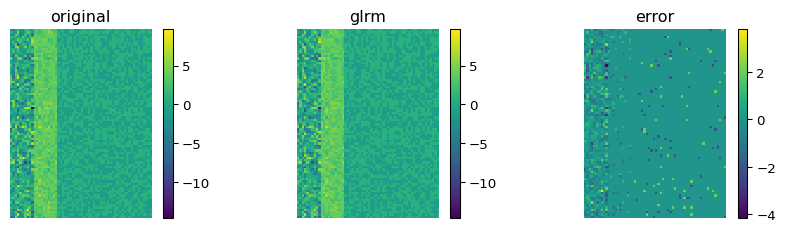

In [92]:
# Example for rank 10

model = GLRM(A, loss, regX, regY, 10, converge = converge, obj_type = 1)
model.fit()

X, Y = model.factors()
A_hat = model.predict() # glrm_pca.predict(X, Y) works too; returns decode(XY)
A_diff = hstack(A)-A_hat # original A minus predicted A
pplot([hstack(A), A_hat, A_diff], ["original", "glrm", "error"])